In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
import tensorflow as tf




#Clean up data
df=pd.read_csv('abalone.data',names=['Sex','Length','Diameter',
                                      'Height','Whole weight','Shucked weight',
                                      'Viscera weight','Shell weight','Rings'])
df=pd.concat([pd.get_dummies(df['Sex']),df],axis=1) #one hot encode feature
del df['Sex']

#Create train, validation, test sets
X_train, X_test, y_train, y_test=train_test_split(df.values[:,:-1],df.values[:,-1],test_size=.2)
X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,test_size=.1)

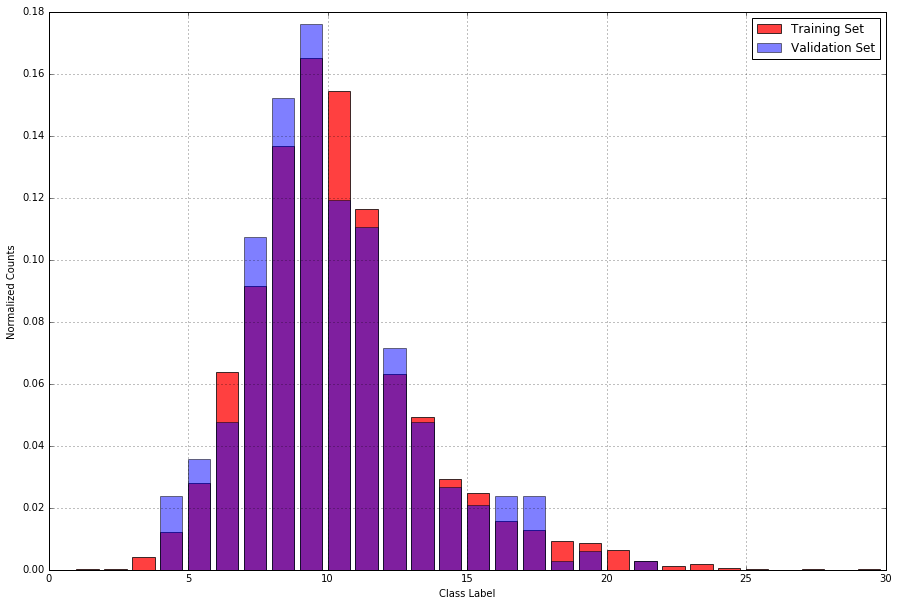

In [9]:
label_counts_train=np.bincount(y_train.astype(np.int))
label_counts_val=np.bincount(y_val.astype(np.int))

label_counts_train=label_counts_train/float(label_counts_train.sum())
label_counts_val=label_counts_val/float(label_counts_val.sum())

ind=np.arange(len(label_counts_train))
_, ax = plt.subplots(figsize=(15,10))
ax.bar(ind,label_counts_train,.8, color='r',alpha=.75)
ind=np.arange(len(label_counts_val))
ax.bar(ind,label_counts_val,.8, color='b',alpha=.5)
plt.legend(('Training Set','Validation Set'))
plt.xlabel('Class Label')
plt.ylabel('Normalized Counts')
plt.grid()
plt.show()

In [3]:
#TODO

def xiaver_init(shape):    
    (fan_in, fan_out) = shape
    low = -4*np.sqrt(6.0/(fan_in + fan_out))
    high = 4*np.sqrt(6.0/(fan_in + fan_out))
    return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))                
                
                
def make_neural_net(X,d,num_hidden,batch_size):

    W_1=tf.truncated_normal(shape=(d,))
    b_1=tf.zeros(shape(1.5*d))
    a_1=tf.matmul(W_1,X)+b_1
    h_1=tf.nn.relu(a_1)
                
    W_2 = xiaver_init((num_hidden,num_labels))#tf.Variable(tf.truncated_normal([ num_hidden,num_labels]))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    
    a_2=tf.matmul(h_1,W_2)+b_2
    
    return a_2

batch_size=10 
d=X_train.shape[-1]
graph=tf.Graph()
                
with graph.as_default():
       
    tf_x_train=tf.placeholder(tf.float32,shape=(batch_size,d]))
    tf_x_val=tf.constant(X_val)
    tf_x_test=tf.constant(X_test)
    
    
    make_neural_net(tf_x_train,d,1.5*d)
                


IndentationError: expected an indented block (<ipython-input-3-5a7dc37b2ccb>, line 6)